In [1]:
from library.objective_function import *
from library.optimiser import *
from library.post_analysis import *
%matplotlib inline

In [3]:
class single_experiment:
    def set_objective(self, objective_func):
        self.objective_func = objective_func

    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

    def do(self):
        optimal, optimum, statistics = self.optimizer.optimise(self.objective_func)
        if np.linalg.norm(optimal - self.objective_func.get_optimal()) < 1e-1 \
        or np.linalg.norm(optimum - self.objective_func.get_optimum()) < 1e-1:
            statistics['status'] = 'global minimum'
        elif statistics['status'] != 'diverge':
            statistics['status'] = 'local minimum'
        cost = np.linalg.norm(optimum - self.objective_func.get_optimum())
        if self.optimizer.verbose:
            print("\nResult: ", statistics['status'])
            print("Cost_val", cost)
        if self.optimizer.record == False:
            return statistics['status'], cost, statistics['evals']
        else:
            self.analyser = post_analysis(statistics, self.objective_func)

In [4]:
class multiple_experiment:
    def set_sample_zone(self, paras):
        self.paras = paras
        self.origin = paras['origin']
        self.edge = paras['edge']
        self.step = paras['step']
        self.sym = paras['sym'] if 'sym' in self.paras.keys() else False
        self.size = paras['size']
    def set_single_exp(self, exp):
        self.exp = exp
    def do(self):
        # get derivative parameters
        num_x = int(self.edge[0] / self.step)
        num_y = int(self.edge[1] / self.step)
        abs_edge = np.zeros((2,))
        abs_edge[0] = self.origin[0] + self.edge[0]
        
        # initlise matrix to record results
        avg_res = np.zeros((num_y, num_x))
        avg_cost = np.zeros_like(avg_res)
        avg_evals = np.zeros_like(avg_res)
        mask = np.ones_like(avg_res, dtype=np.uint8)
        position_x = np.zeros_like(avg_res)
        position_y = np.zeros_like(avg_res)
        
        for i, x in enumerate(np.arange(self.origin[0], abs_edge[0], self.step)):
            if self.sym:
                abs_edge[1] = self.origin[1] + x + self.step 
            else:
                abs_edge[1] = self.origin[1] + self.edge[1]
            for j, y in enumerate(np.arange(self.origin[1], abs_edge[1], self.step)):
                points = np.random.rand(self.size, 2) * self.step + np.array([x, y]) 
                mask[num_y-1-j, i] = 0
                position_x[num_y-1-j, i] = x
                position_y[num_y-1-j, i] = y
                opt_paras = self.exp.optimizer.paras
                # calculate the probility of getting global minimum 
                res = np.zeros((self.size, ))
                costs = np.zeros_like(res)
                evals = np.zeros_like(res)
                for k in range(self.size):
                    opt_paras['mean0'] = points[k].reshape(2,1)
                    self.exp.optimizer.set_parameters(opt_paras)
                    status, costs[k], evals[k] = self.exp.do()
                    if(status == 'global minimum'):
                        res[k] = 1
                avg_res[num_y-1-j, i] = np.mean(res)
                avg_cost[num_y-1-j, i] = np.mean(costs)
                avg_evals[num_y-1-j, i] = np.mean(evals)
        data = {'x': position_x, 
                'y': position_y,
                'mask': mask,
                'res': avg_res,
                'cost': avg_cost,
                'evals': avg_evals}
        self.analyser = post_analysis_multiple(self.paras, data)
        return data

# Original Ackley + Original CMA

In [25]:
np.random.seed(23191)

# init multiple experiments
exps = multiple_experiment()

# init and setup one experiment
exp = single_experiment()

# One experiment: setup objective function
ak = ackley()
exp.set_objective(ak)

# One experiment: setup optimizer
cma = cma_es()
paras = {'mean0': np.zeros((2,)),
         'std': np.ones((2,)) * 3, 
         'tol': 1e-5, 
         'adjust_func': do_nothing(), 
         'record': False, 
         'verbose': False}
cma.set_parameters(paras)
exp.set_optimizer(cma)

# Multiple experiment: setup one expreiment
exps.set_single_exp(exp)


# Multiple experiments: setup sample zone of multiple experiments
expsParas = {'origin': np.array([0,0]),
             'edge': np.array([500, 500]),
             'step': 20,
             'size': 10,
             'sym': True}
exps.set_sample_zone(expsParas)

data = exps.do()

/Users/huajian/Non-convex/library/optimiser.py:199: RuntimeWarning:

invalid value encountered in sqrt

/Users/huajian/miniconda3/envs/ada/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning:

invalid value encountered in reduce

/Users/huajian/Non-convex/library/optimiser.py:90: RuntimeWarning:

invalid value encountered in less

/Users/huajian/Non-convex/library/optimiser.py:93: RuntimeWarning:

invalid value encountered in less



diverge, raise LinAlgError!
diverge, raise LinAlgError!
diverge, raise LinAlgError!
diverge, concentrate in low dimension manifold
diverge, raise LinAlgError!
diverge, raise LinAlgError!
diverge, concentrate in low dimension manifold
diverge, raise LinAlgError!
diverge, raise LinAlgError!
diverge, raise LinAlgError!
diverge, raise LinAlgError!
diverge, raise LinAlgError!
diverge, raise LinAlgError!
diverge, concentrate in low dimension manifold
diverge, raise LinAlgError!
diverge, raise LinAlgError!


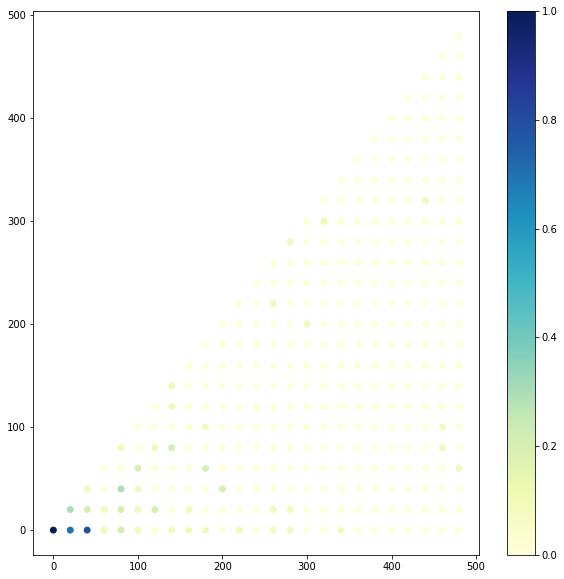

In [35]:
exps.analyser.plot_scatter()

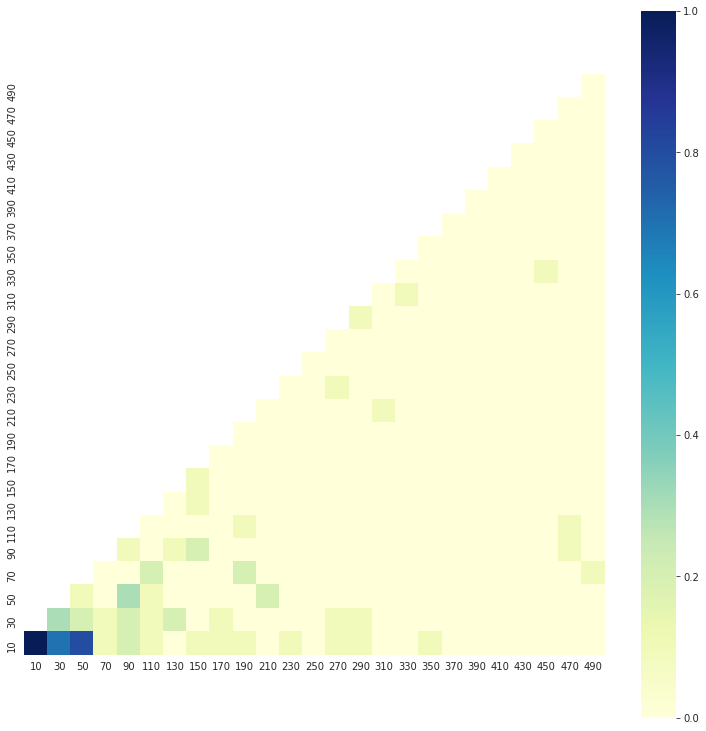

In [27]:
exps.analyser.plot_hotmap_prob()

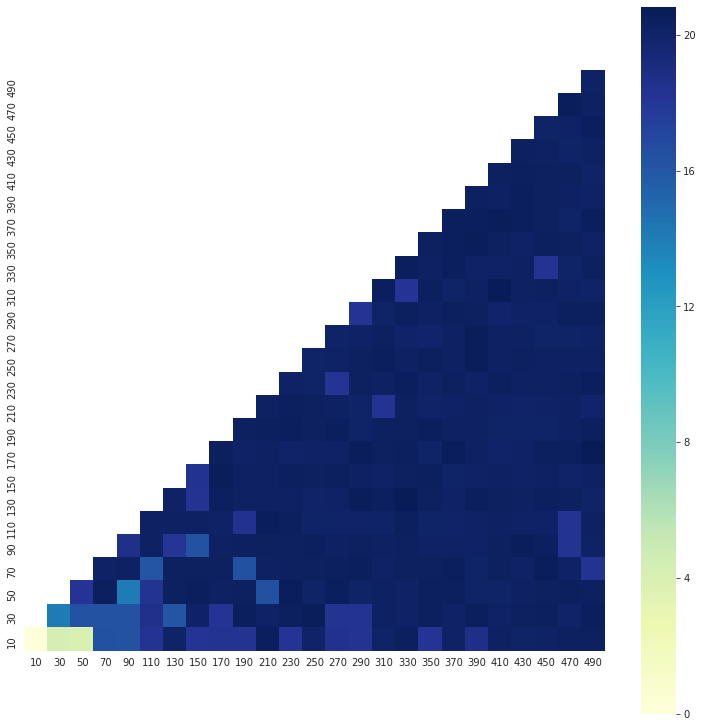

In [28]:
exps.analyser.plot_hotmap_cost()

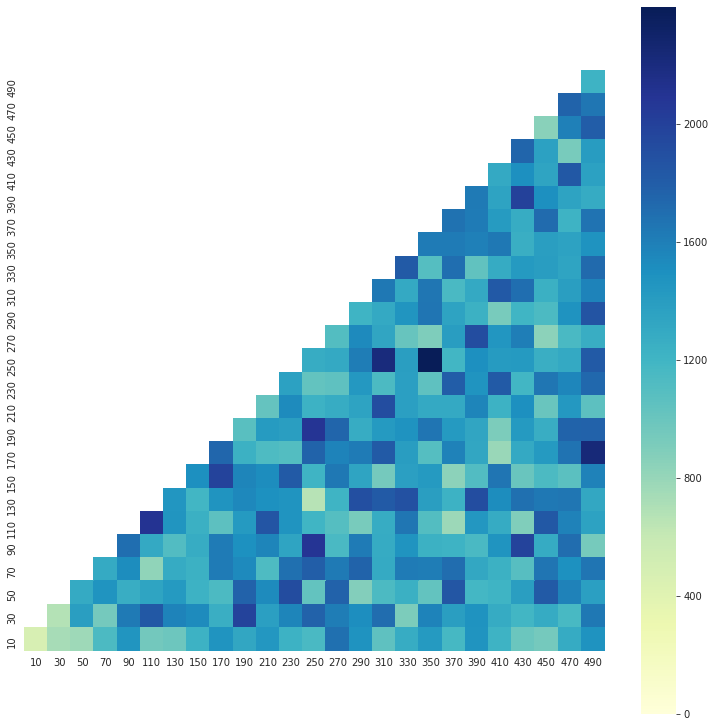

In [29]:
exps.analyser.plot_hotmap_evals()

# Original Ackley + CMA-line search(round off)

In [32]:
np.random.seed(23191)

# init multiple experiments
exps2 = multiple_experiment()

# init and setup one experiment
exp = single_experiment()

# One experiment: setup objective function
ak = ackley()
exp.set_objective(ak)

# One experiment: setup optimizer
cma = cma_es()
paras = {'mean0': np.zeros((2,)),
         'std': np.ones((2,)) * 3, 
         'tol': 1e-5, 
         'adjust_func': round_off(), 
         'record': False, 
         'verbose': False}
cma.set_parameters(paras)
exp.set_optimizer(cma)

# Multiple experiment: setup one expreiment
exps2.set_single_exp(exp)


# Multiple experiments: setup sample zone of multiple experiments
expsParas = {'origin': np.array([0,0]),
             'edge': np.array([500, 500]),
             'step': 20,
             'size': 10,
             'sym': True}
exps2.set_sample_zone(expsParas)

data2 = exps2.do()

diverge, raise LinAlgError!
diverge, raise LinAlgError!
diverge, raise LinAlgError!
diverge, raise LinAlgError!
diverge, raise LinAlgError!
diverge, raise LinAlgError!
diverge, concentrate in low dimension manifold
diverge, concentrate in low dimension manifold
diverge, concentrate in low dimension manifold
diverge, concentrate in low dimension manifold


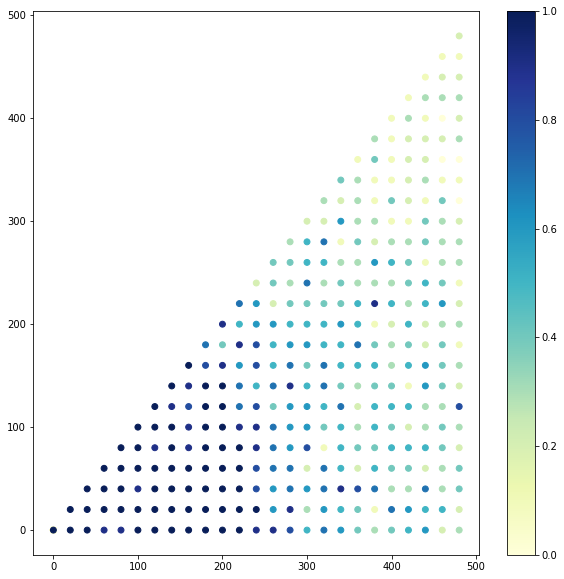

In [33]:
exps2.analyser.plot_scatter()

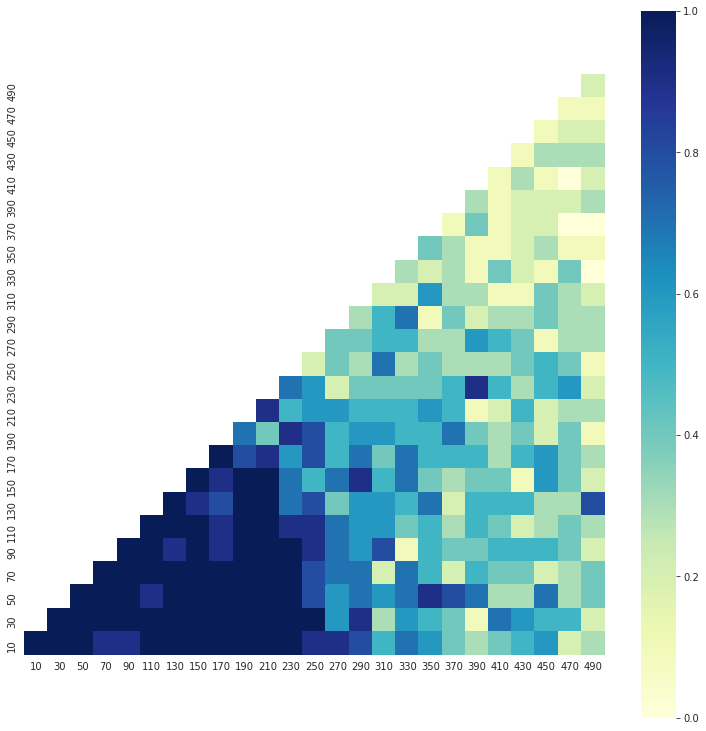

In [36]:
exps2.analyser.plot_hotmap_prob()

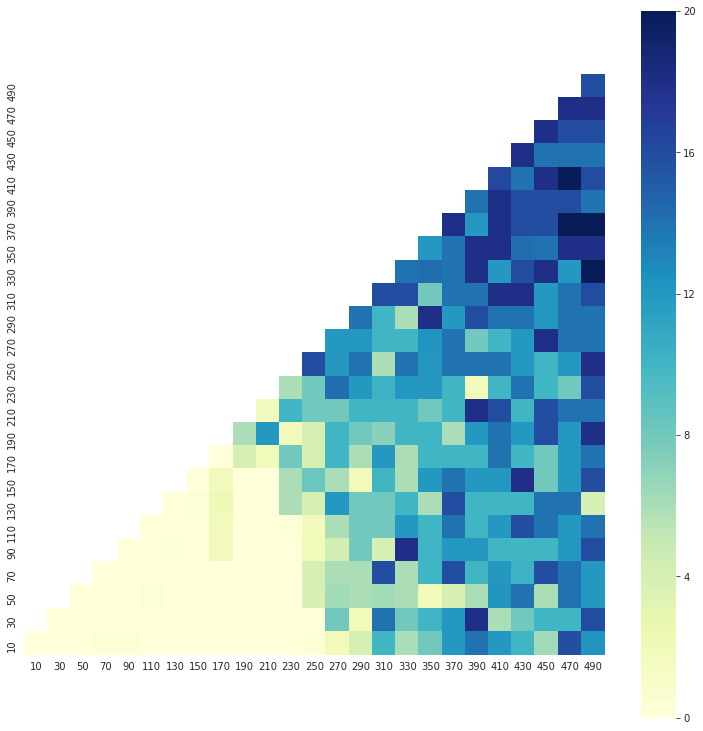

In [37]:
exps2.analyser.plot_hotmap_cost()

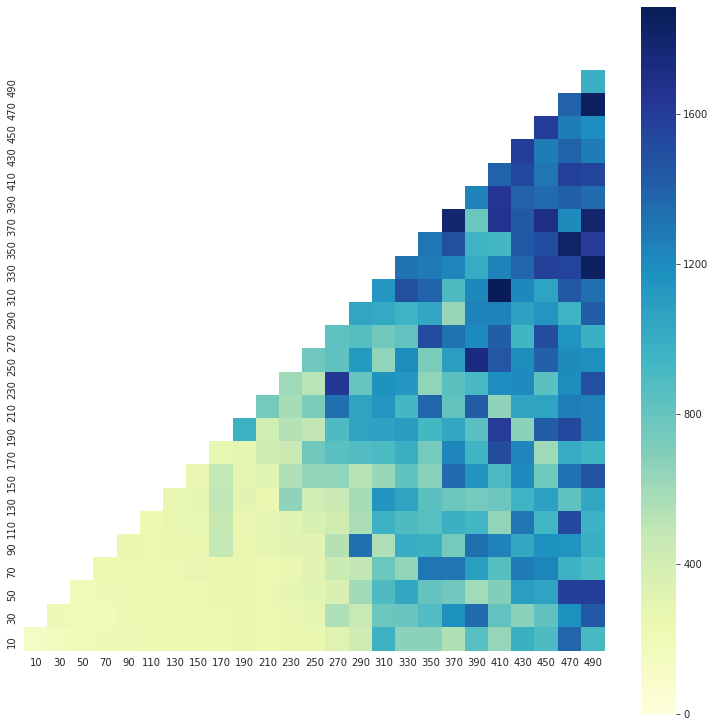

In [38]:
exps2.analyser.plot_hotmap_evals()

# bukin + original CMA

In [8]:
np.random.seed(23191)

# init multiple experiments
exps3 = multiple_experiment()

# init and setup one experiment
exp = single_experiment()

# One experiment: setup objective function
bk = bukin()
exp.set_objective(bk)

# One experiment: setup optimizer
cma = cma_es()
paras = {'mean0': np.zeros((2,)),
         'std': np.ones((2,)) * 0.003, 
         'tol': 1e-5, 
         'adjust_func': do_nothing(), 
         'record': False, 
         'verbose': False}
cma.set_parameters(paras)
exp.set_optimizer(cma)

# Multiple experiment: setup one expreiment
exps3.set_single_exp(exp)


# Multiple experiments: setup sample zone of multiple experiments
expsParas = {'origin': np.array([-15, -5]),
             'edge': np.array([30, 10]),
             'step': 1,
             'size': 10,
             'sym': False}
exps3.set_sample_zone(expsParas)

%time data3 = exps3.do()

diverge, concentrate in low dimension manifold
diverge, concentrate in low dimension manifold
diverge, concentrate in low dimension manifold
diverge, concentrate in low dimension manifold
diverge, concentrate in low dimension manifold
diverge, concentrate in low dimension manifold
diverge, concentrate in low dimension manifold
diverge, concentrate in low dimension manifold
diverge, concentrate in low dimension manifold
diverge, concentrate in low dimension manifold
diverge, concentrate in low dimension manifold
diverge, concentrate in low dimension manifold
diverge, concentrate in low dimension manifold
diverge, concentrate in low dimension manifold
diverge, concentrate in low dimension manifold
diverge, concentrate in low dimension manifold
diverge, concentrate in low dimension manifold
diverge, concentrate in low dimension manifold
diverge, concentrate in low dimension manifold
diverge, concentrate in low dimension manifold
diverge, concentrate in low dimension manifold
diverge, conc

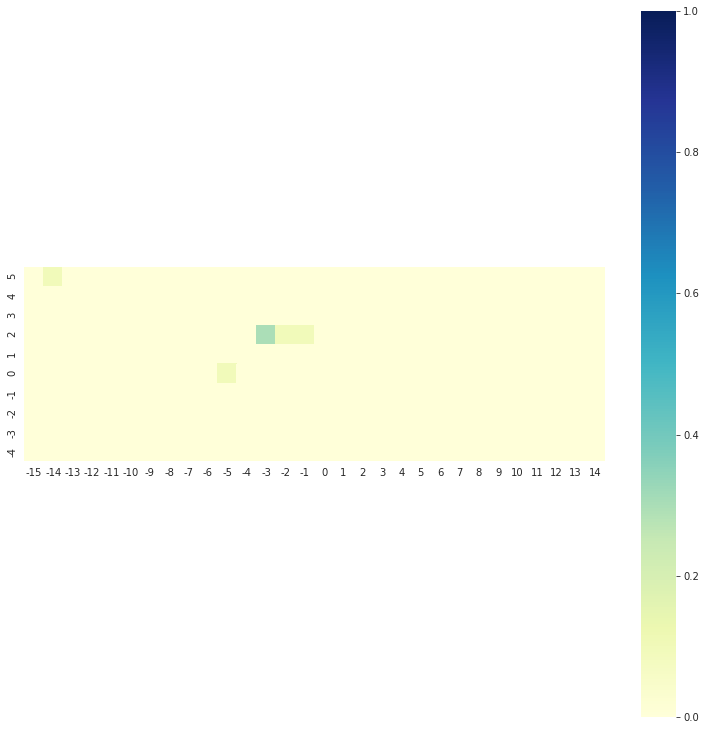

In [9]:
exps3.analyser.plot_hotmap_prob()

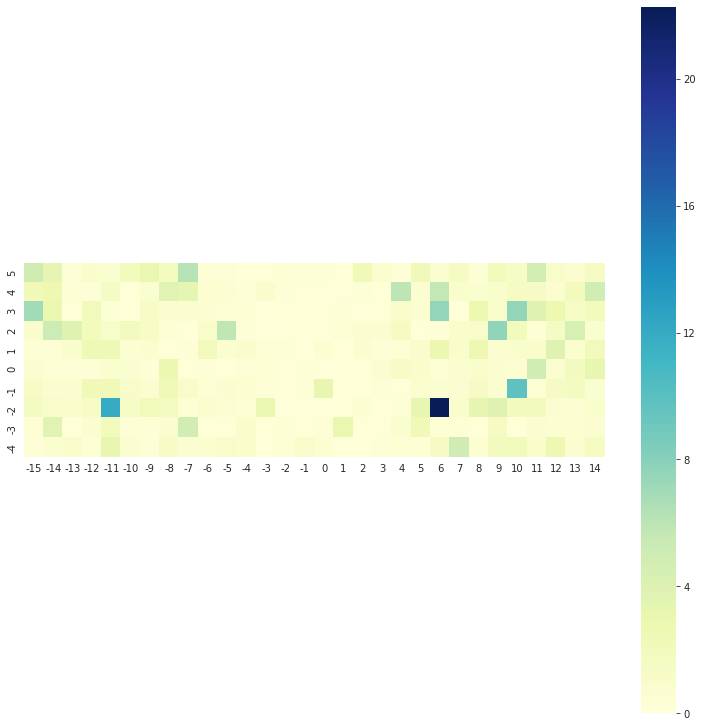

In [10]:
exps3.analyser.plot_hotmap_cost()

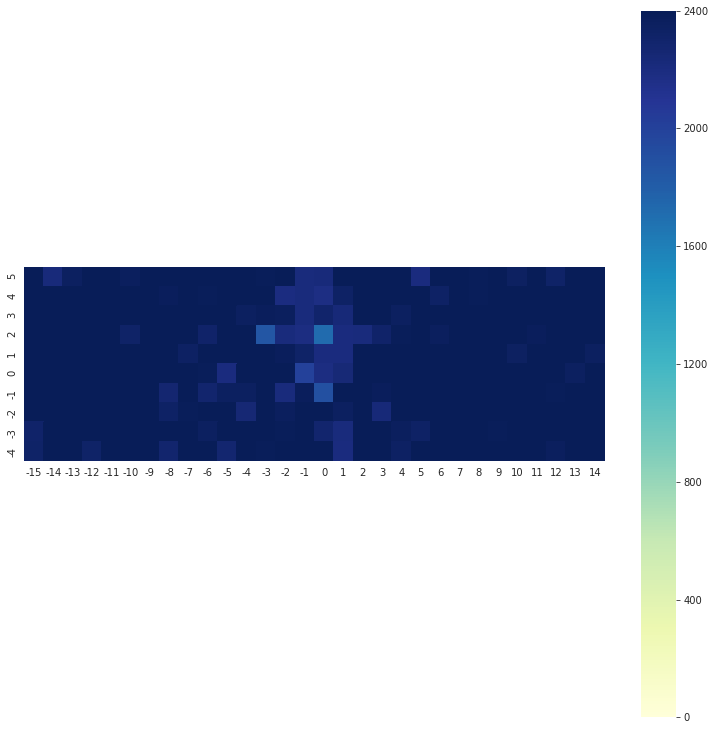

In [11]:
exps3.analyser.plot_hotmap_evals()

# test the effiency of optimizer

In [34]:
np.random.seed(23191)

# init multiple experiments
exps3 = multiple_experiment()

# init and setup one experiment
exp = single_experiment()

# One experiment: setup objective function
bk = bukin()
exp.set_objective(bk)

# One experiment: setup optimizer
cma = cma_es()
paras = {'mean0': np.zeros((2,)),
         'std': np.ones((2,)) * 0.003, 
         'tol': 1e-5, 
         'adjust_func': do_nothing(), 
         'record': False, 
         'verbose': True}
cma.set_parameters(paras)
exp.set_optimizer(cma)

# Multiple experiment: setup one expreiment
exps3.set_single_exp(exp)


# Multiple experiments: setup sample zone of multiple experiments
expsParas = {'origin': np.array([-15, -5]),
             'edge': np.array([30, 10]),
             'step': 10,
             'size': 10,
             'sym': False}
exps3.set_sample_zone(expsParas)

%time data3 = exps3.do()

CPU times: user 4.37 s, sys: 26.5 ms, total: 4.39 s
Wall time: 4.46 s


In [23]:
data3['evals'].mean()

2338.2000000000003

In [25]:
np.random.seed(2311)

# init multiple experiments
exps3 = multiple_experiment()

# init and setup one experiment
exp = single_experiment()

# One experiment: setup objective function
bk = bukin()
exp.set_objective(bk)

# One experiment: setup optimizer
cma = cma_es()
paras = {'mean0': np.zeros((2,)),
         'std': np.ones((2,)) * 0.003, 
         'tol': 1e-5, 
         'adjust_func': line_search(alpha=1e-5, beta=2e-5), 
         'record': False, 
         'verbose': True}
cma.set_parameters(paras)
exp.set_optimizer(cma)

# Multiple experiment: setup one expreiment
exps3.set_single_exp(exp)


# Multiple experiments: setup sample zone of multiple experiments
expsParas = {'origin': np.array([-15, -5]),
             'edge': np.array([30, 10]),
             'step': 10,
             'size': 10,
             'sym': False}
exps3.set_sample_zone(expsParas)

%time data3 = exps3.do()

*******starting optimisation from intitial mean:  [-11.78435322   3.46011435]
eigenvalue of variance = [1.99778078e-05 1.60207729e-06]
total iterations = 103, total evaluatios = 146158
found minimum position = [-10.00041755   1.00008351], found minimum = 4.175493681675136e-06

Result:  global minimum
Cost_val 4.175493681675136e-06
*******starting optimisation from intitial mean:  [-12.81228372  -3.50519404]
eigenvalue of variance = [1.11602795e-04 1.31867028e-05]
total iterations = 71, total evaluatios = 103683
found minimum position = [-10.00007169   1.00001434], found minimum = 7.168741138308121e-07

Result:  global minimum
Cost_val 7.168741138308121e-07
*******starting optimisation from intitial mean:  [-14.48877418   2.08050548]
eigenvalue of variance = [1.17433096e-05 1.01655789e-06]
total iterations = 122, total evaluatios = 167021
found minimum position = [-10.00017709   1.00003542], found minimum = 1.7708511827585483e-06

Result:  global minimum
Cost_val 1.7708511827585483e-06


/Users/huajian/Non-convex/library/optimiser.py:199: RuntimeWarning:

invalid value encountered in sqrt

/Users/huajian/miniconda3/envs/ada/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning:

invalid value encountered in reduce

/Users/huajian/Non-convex/library/optimiser.py:90: RuntimeWarning:

invalid value encountered in less

/Users/huajian/Non-convex/library/optimiser.py:93: RuntimeWarning:

invalid value encountered in less



diverge, raise LinAlgError!
eigenvalue of variance = [           nan 1.93922023e-06]
total iterations = 169, total evaluatios = 231104
found minimum position = [-6.58779264e+94  1.27986317e+96], found minimum = 6.594380430352801e+95

Result:  diverge
Cost_val 6.594380430352801e+95
*******starting optimisation from intitial mean:  [-13.81537333   1.6964637 ]
eigenvalue of variance = [3.26346260e-13 5.96204821e-12]
total iterations = 400, total evaluatios = 542340
found minimum position = [-133.81954945  944.80897005], found minimum = 2768.4249472177826

Result:  local minimum
Cost_val 2768.4249472177826
*******starting optimisation from intitial mean:  [-11.45160413   1.26605073]
eigenvalue of variance = [4.03099835e-05 4.91672161e-06]
total iterations = 90, total evaluatios = 128436
found minimum position = [-9.99980055  0.99996011], found minimum = 1.9944651781855784e-06

Result:  global minimum
Cost_val 1.9944651781855784e-06
*******starting optimisation from intitial mean:  [-3.3281

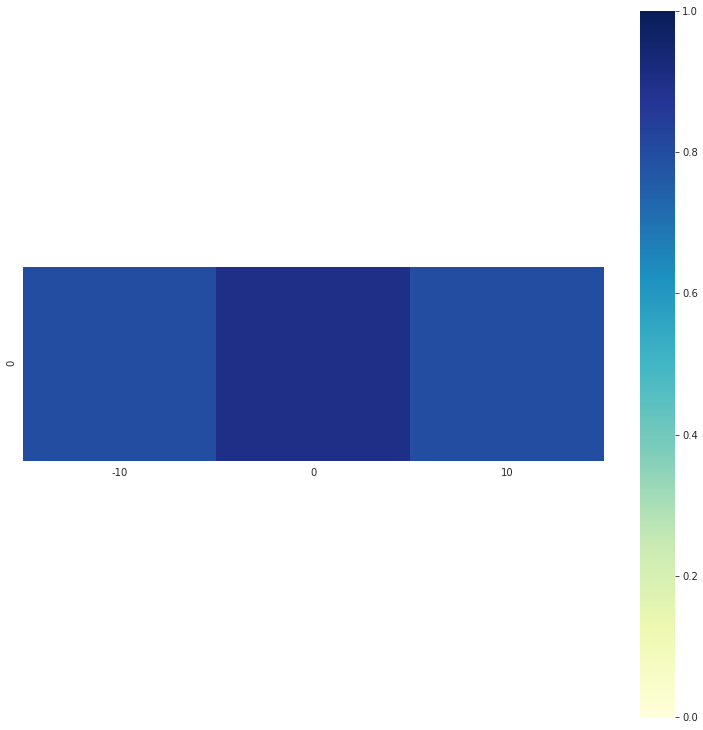

In [26]:
exps3.analyser.plot_hotmap_prob()

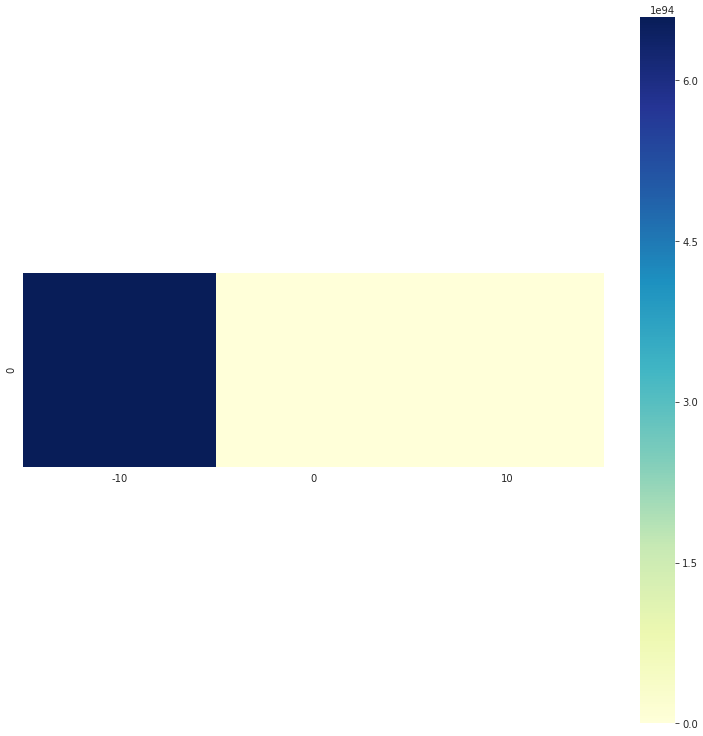

In [27]:
exps3.analyser.plot_hotmap_cost()

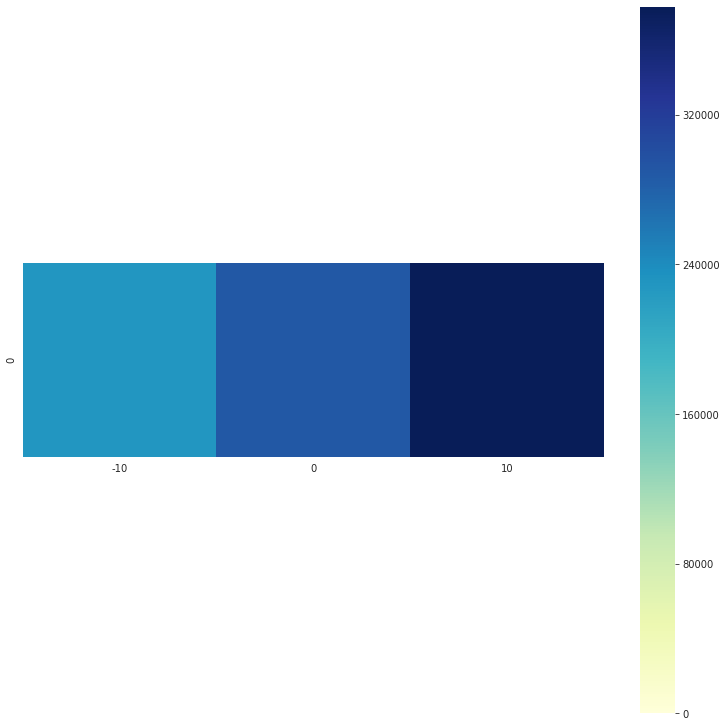

In [28]:
exps3.analyser.plot_hotmap_evals()

In [29]:
data3

{'x': array([[-15.,  -5.,   5.]]),
 'y': array([[-5., -5., -5.]]),
 'mask': array([[0, 0, 0]], dtype=uint8),
 'res': array([[0.8, 0.9, 0.8]]),
 'cost': array([[6.59438043e+94, 2.14207190e+04, 2.65597313e+02]]),
 'evals': array([[229115.4, 290124.5, 377703. ]])}

## summary of bukin
| -- | line search (very small step size) - CMA | original CMA |
| -- | -- | --|
| #experiments| 30 experiments | 30 experiments |
| total time| 111 s | 4.5 s |
| evalutaions per exp | 299 k evals |  2.3 k evals |

# bukin + CMA-line search

In [8]:
np.random.seed(23191)

# init multiple experiments
exps3 = multiple_experiment()

# init and setup one experiment
exp = single_experiment()

# One experiment: setup objective function
bk = bukin()
exp.set_objective(bk)

# One experiment: setup optimizer
cma = cma_es()
paras = {'mean0': np.zeros((2,)),
         'std': np.ones((2,)) * 0.003, 
         'tol': 1e-5, 
         'adjust_func': line_search(alpha=1e-5, beta=2e-5), 
         'record': False, 
         'verbose': True}
cma.set_parameters(paras)
exp.set_optimizer(cma)

# Multiple experiment: setup one expreiment
exps3.set_single_exp(exp)


# Multiple experiments: setup sample zone of multiple experiments
expsParas = {'origin': np.array([-15, -5]),
             'edge': np.array([30, 10]),
             'step': 1,
             'size': 10,
             'sym': False}
exps3.set_sample_zone(expsParas)

data3 = exps3.do()

*******starting optimisation from intitial mean:  [-14.3768192   -4.24151732]
eigenvalue of variance = [7.45041219e-06 7.92537777e-07]
total iterations = 113, total evaluatios = 161631
found minimum position = [-9.99951757  0.99990352], found minimum = 4.824318651142079e-06

Result:  global minimum
Cost_val 4.824318651142079e-06
*******starting optimisation from intitial mean:  [-14.49280119  -4.5392226 ]
eigenvalue of variance = [1.53112626e-04 1.46266136e-05]
total iterations = 71, total evaluatios = 104648
found minimum position = [-10.00017557   1.00003511], found minimum = 1.7556997181245037e-06

Result:  global minimum
Cost_val 1.7556997181245037e-06
*******starting optimisation from intitial mean:  [-14.28298957  -4.42280431]
eigenvalue of variance = [1.32649252e-07 1.44369068e-08]
total iterations = 180, total evaluatios = 242153
found minimum position = [-10.00005762   1.00001152], found minimum = 5.7623394729589e-07

Result:  global minimum
Cost_val 5.7623394729589e-07
******

KeyboardInterrupt: 

# tuned ackley + original CMA

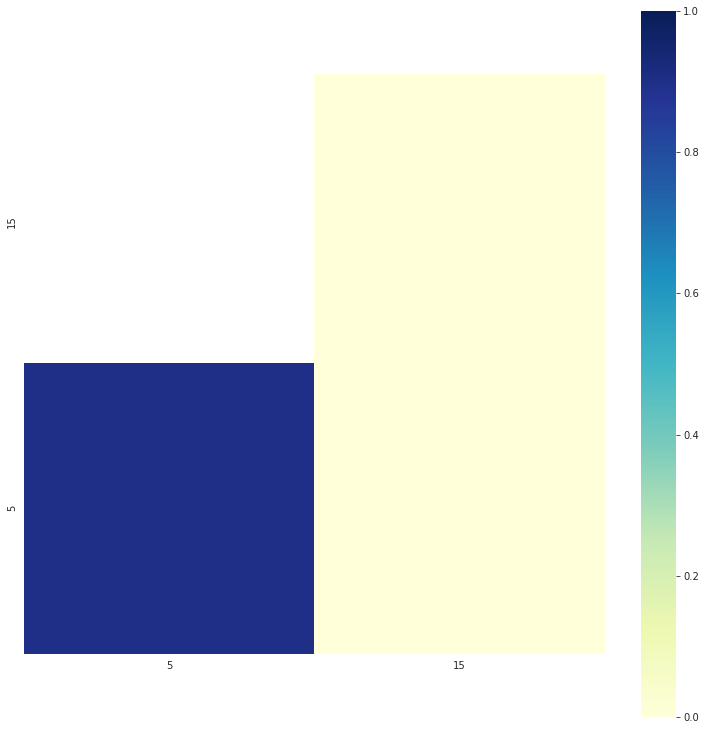

In [37]:
exps5.analyser.plot_hotmap_prob()

In [48]:
np.random.seed(2311)

# init multiple experiments
exps5 = multiple_experiment()

# init and setup one experiment
exp = single_experiment()

# One experiment: setup objective function
tak = tuned_ackley()
exp.set_objective(tak)

# One experiment: setup optimizer
cma = cma_es()
paras = {'mean0': np.zeros((2,)),
         'std': np.ones((2,)) * 3, 
         'tol': 1e-5, 
         'adjust_func': do_nothing(), 
         'record': False, 
         'verbose': False}
cma.set_parameters(paras)
exp.set_optimizer(cma)

# Multiple experiment: setup one expreiment
exps5.set_single_exp(exp)


# Multiple experiments: setup sample zone of multiple experiments
expsParas = {'origin': np.array([0, 0]),
             'edge': np.array([20, 20]),
             'step': 5,
             'size': 10,
             'sym': True}
exps5.set_sample_zone(expsParas)

%time data5 = exps5.do()

CPU times: user 3.78 s, sys: 32 ms, total: 3.81 s
Wall time: 3.9 s


In [49]:
data5

{'x': array([[ 0.,  0.,  0., 15.],
        [ 0.,  0., 10., 15.],
        [ 0.,  5., 10., 15.],
        [ 0.,  5., 10., 15.]]),
 'y': array([[ 0.,  0.,  0., 15.],
        [ 0.,  0., 10., 10.],
        [ 0.,  5.,  5.,  5.],
        [ 0.,  0.,  0.,  0.]]),
 'mask': array([[1, 1, 1, 0],
        [1, 1, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 0, 0]], dtype=uint8),
 'res': array([[0. , 0. , 0. , 0.8],
        [0. , 0. , 0.7, 0.8],
        [0. , 1. , 0.7, 0.5],
        [1. , 1. , 0.7, 0.3]]),
 'cost': array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.45635286e+00],
        [0.00000000e+00, 0.00000000e+00, 2.23369673e+00, 1.38818818e+00],
        [0.00000000e+00, 5.62749786e-06, 1.88484099e+00, 3.09685665e+00],
        [5.39433164e-06, 6.18785808e-06, 1.81758492e+00, 4.94348520e+00]]),
 'evals': array([[  0. ,   0. ,   0. , 950.4],
        [  0. ,   0. , 475.2, 507.6],
        [  0. , 435.6, 479.4, 456. ],
        [414. , 425.4, 451.8, 481.2]])}

In [58]:
data5['evals'].sum()/10

507.66

In [59]:
data5['cost'].sum()/10

2.482102273543969

In [60]:
data5['res'].sum()/10

0.75

In [42]:
# with too small std
data5

{'x': array([[ 0.,  0.,  0., 15.],
        [ 0.,  0., 10., 15.],
        [ 0.,  5., 10., 15.],
        [ 0.,  5., 10., 15.]]),
 'y': array([[ 0.,  0.,  0., 15.],
        [ 0.,  0., 10., 10.],
        [ 0.,  5.,  5.,  5.],
        [ 0.,  0.,  0.,  0.]]),
 'mask': array([[1, 1, 1, 0],
        [1, 1, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 0, 0]], dtype=uint8),
 'res': array([[0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. ],
        [0. , 0.4, 0. , 0. ],
        [1. , 0.9, 0.1, 0. ]]),
 'cost': array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.72817182e+01],
        [0.00000000e+00, 0.00000000e+00, 1.52224964e+01, 4.72817182e+01],
        [0.00000000e+00, 8.38348501e+00, 1.26473405e+01, 3.92524218e+01],
        [6.63354127e-06, 1.40075515e+00, 1.55405996e+01, 1.30243484e+01]]),
 'evals': array([[  0. ,   0. ,   0. ,  12. ],
        [  0. ,   0. , 294. ,  12. ],
        [  0. , 388.8, 270. , 120.6],
        [495.6, 511.8, 526.8, 474.6]])}

In [45]:
np.random.seed(2311)

# init multiple experiments
exps6 = multiple_experiment()

# init and setup one experiment
exp = single_experiment()

# One experiment: setup objective function
tak = tuned_ackley()
exp.set_objective(tak)

# One experiment: setup optimizer
cma = cma_es()
paras = {'mean0': np.zeros((2,)),
         'std': np.ones((2,)) * 3, 
         'tol': 1e-5, 
         'adjust_func': line_search(), 
         'record': False, 
         'verbose': True}
cma.set_parameters(paras)
exp.set_optimizer(cma)

# Multiple experiment: setup one expreiment
exps6.set_single_exp(exp)


# Multiple experiments: setup sample zone of multiple experiments
expsParas = {'origin': np.array([0, 0]),
             'edge': np.array([20, 20]),
             'step': 5,
             'size': 10,
             'sym': True}
exps6.set_sample_zone(expsParas)

%time data6 = exps6.do()

*******starting optimisation from intitial mean:  [1.60782339 4.23005717]
eigenvalue of variance = [8.33563956 8.95129919]
total iterations = 2, total evaluatios = 3078
found minimum position = [-1.37357633e-16  2.75345356e-16], found minimum = 2.718281828459045

Result:  global minimum
Cost_val 0.0
*******starting optimisation from intitial mean:  [1.09385814 0.74740298]
eigenvalue of variance = [8.25498265 7.87325515]
total iterations = 2, total evaluatios = 3082
found minimum position = [ 1.37383957e-17 -5.54788123e-17], found minimum = 2.718281828459045

Result:  global minimum
Cost_val 0.0
*******starting optimisation from intitial mean:  [0.25561291 3.54025274]
eigenvalue of variance = [6.997661   7.85490619]
total iterations = 3, total evaluatios = 4411
found minimum position = [-4.67164890e-17  1.42317651e-16], found minimum = 2.718281828459045

Result:  global minimum
Cost_val 0.0
*******starting optimisation from intitial mean:  [0.07394369 0.62737156]
eigenvalue of variance 

eigenvalue of variance = [5.95712403 6.59938585]
total iterations = 5, total evaluatios = 6066
found minimum position = [-1.74618385e-16  1.18680992e-16], found minimum = 2.718281828459045

Result:  global minimum
Cost_val 0.0
*******starting optimisation from intitial mean:  [6.03989406 5.65400526]
eigenvalue of variance = [6.45244274 5.94672243]
total iterations = 5, total evaluatios = 6506
found minimum position = [-1.74083306e-16 -1.35555516e-16], found minimum = 2.718281828459045

Result:  global minimum
Cost_val 0.0
*******starting optimisation from intitial mean:  [10.11289774  2.76918482]
eigenvalue of variance = [5.85651092 4.94257307]
total iterations = 7, total evaluatios = 8063
found minimum position = [-1.81354369e-16  2.22621230e-16], found minimum = 2.718281828459045

Result:  global minimum
Cost_val 0.0
*******starting optimisation from intitial mean:  [14.20255606  2.97973553]
eigenvalue of variance = [5.30783973 4.34347314]
total iterations = 9, total evaluatios = 833

eigenvalue of variance = [5.00945712 3.69642401]
total iterations = 25, total evaluatios = 9284
found minimum position = [ 4.41512624e-17 -9.38989689e-17], found minimum = 2.718281828459045

Result:  global minimum
Cost_val 0.0
*******starting optimisation from intitial mean:  [11.58817722 12.20191887]
eigenvalue of variance = [6.36122977 5.22316445]
total iterations = 11, total evaluatios = 6902
found minimum position = [9.04526124e-17 8.21584862e-18], found minimum = 2.718281828459045

Result:  global minimum
Cost_val 0.0
*******starting optimisation from intitial mean:  [13.53187705 10.59014128]
eigenvalue of variance = [2.78587274 1.66875253]
total iterations = 34, total evaluatios = 14290
found minimum position = [1.69980480e-16 1.56783989e-16], found minimum = 2.718281828459045

Result:  global minimum
Cost_val 0.0
*******starting optimisation from intitial mean:  [12.04609657 11.36269496]
eigenvalue of variance = [0.18516856 0.2792562 ]
total iterations = 91, total evaluatios = 

eigenvalue of variance = [0.00011549 0.03821643]
total iterations = 400, total evaluatios = 25219
found minimum position = [ 1.00150467e+06 -6.26494268e+08], found minimum = 50.0

Result:  local minimum
Cost_val 47.28171817154095
*******starting optimisation from intitial mean:  [18.94514993 14.43176413]
eigenvalue of variance = [8.50589112 3.50519205]
total iterations = 18, total evaluatios = 7583
found minimum position = [-6.70002337e-17  8.09882101e-17], found minimum = 2.718281828459045

Result:  global minimum
Cost_val 0.0
*******starting optimisation from intitial mean:  [18.69597077 12.69586538]
eigenvalue of variance = [0.01435886 0.10822739]
total iterations = 139, total evaluatios = 32022
found minimum position = [18.00947525 -6.00317064], found minimum = 7.2460652123026925

Result:  local minimum
Cost_val 4.527783383843648
*******starting optimisation from intitial mean:  [16.91320578 11.53057657]
eigenvalue of variance = [3.71212446 4.04986693]
total iterations = 11, total 

In [47]:
data6['evals'].sum()/10

11519.630000000001

In [54]:
data6['res'].sum()/10

0.8

In [55]:
data6['cost'].sum()/10

2.2018393800209695

In [46]:
data6

{'x': array([[ 0.,  0.,  0., 15.],
        [ 0.,  0., 10., 15.],
        [ 0.,  5., 10., 15.],
        [ 0.,  5., 10., 15.]]),
 'y': array([[ 0.,  0.,  0., 15.],
        [ 0.,  0., 10., 10.],
        [ 0.,  5.,  5.,  5.],
        [ 0.,  0.,  0.,  0.]]),
 'mask': array([[1, 1, 1, 0],
        [1, 1, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 0, 0]], dtype=uint8),
 'res': array([[0. , 0. , 0. , 0.5],
        [0. , 0. , 1. , 0.8],
        [0. , 0.9, 1. , 0.5],
        [1. , 1. , 0.8, 0.5]]),
 'cost': array([[0.        , 0.        , 0.        , 6.6481679 ],
        [0.        , 0.        , 0.        , 5.18095016],
        [0.        , 0.48188212, 0.        , 6.53427236],
        [0.        , 0.        , 0.90555667, 2.2675646 ]]),
 'evals': array([[    0. ,     0. ,     0. ,  9072.2],
        [    0. ,     0. , 10802.5, 13253.4],
        [    0. ,  6635.6,  8912.6, 31238.1],
        [ 4020.8,  6894. ,  8645.7, 15721.4]])}

In [44]:
# with too small std
data6

{'x': array([[ 0.,  0.,  0., 15.],
        [ 0.,  0., 10., 15.],
        [ 0.,  5., 10., 15.],
        [ 0.,  5., 10., 15.]]),
 'y': array([[ 0.,  0.,  0., 15.],
        [ 0.,  0., 10., 10.],
        [ 0.,  5.,  5.,  5.],
        [ 0.,  0.,  0.,  0.]]),
 'mask': array([[1, 1, 1, 0],
        [1, 1, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 0, 0]], dtype=uint8),
 'res': array([[0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. ],
        [0. , 0.2, 0.1, 0. ],
        [0. , 0.2, 0.1, 0. ]]),
 'cost': array([[ 0.        ,  0.        ,  0.        , 47.28171817],
        [ 0.        ,  0.        , 47.28171817, 47.28171817],
        [ 0.        , 37.82537454, 42.55354635, 47.28171817],
        [47.28171817, 37.82537454, 42.55354635, 47.28171817]]),
 'evals': array([[    0. ,     0. ,     0. ,    72. ],
        [    0. ,     0. , 10342.4,  1513.2],
        [    0. , 12171.6, 11578.5,  5881.1],
        [ 6778.5,  7363.7, 12095.5, 11980.3]])}

In [51]:
np.random.seed(2311)

# init multiple experiments
exps6_2 = multiple_experiment()

# init and setup one experiment
exp = single_experiment()

# One experiment: setup objective function
tak = tuned_ackley()
exp.set_objective(tak)

# One experiment: setup optimizer
cma = cma_es()
paras = {'mean0': np.zeros((2,)),
         'std': np.ones((2,)) * 3, 
         'tol': 1e-5, 
         'adjust_func': round_off(), 
         'record': False, 
         'verbose': False}
cma.set_parameters(paras)
exp.set_optimizer(cma)

# Multiple experiment: setup one expreiment
exps6_2.set_single_exp(exp)


# Multiple experiments: setup sample zone of multiple experiments
expsParas = {'origin': np.array([0, 0]),
             'edge': np.array([20, 20]),
             'step': 5,
             'size': 10,
             'sym': True}
exps6_2.set_sample_zone(expsParas)

%time data6_2 = exps6_2.do()

*******starting optimisation from intitial mean:  [1.60782339 4.23005717]
eigenvalue of variance = [2.86510231 3.26811919]
total iterations = 13, total evaluatios = 78
found minimum position = [ 0. -0.], found minimum = 2.718281828459045

Result:  global minimum
Cost_val 0.0
*******starting optimisation from intitial mean:  [1.09385814 0.74740298]
eigenvalue of variance = [3.52133435 2.84828021]
total iterations = 14, total evaluatios = 84
found minimum position = [-0. -0.], found minimum = 2.718281828459045

Result:  global minimum
Cost_val 0.0
*******starting optimisation from intitial mean:  [0.25561291 3.54025274]
eigenvalue of variance = [2.60078165 2.81862473]
total iterations = 16, total evaluatios = 96
found minimum position = [-0.  0.], found minimum = 2.718281828459045

Result:  global minimum
Cost_val 0.0
*******starting optimisation from intitial mean:  [0.07394369 0.62737156]
eigenvalue of variance = [1.95542722 2.4673855 ]
total iterations = 20, total evaluatios = 120
fou

eigenvalue of variance = [2.40650271 4.4527016 ]
total iterations = 15, total evaluatios = 90
found minimum position = [18.  6.], found minimum = 7.259938271245506

Result:  local minimum
Cost_val 4.541656442786461
*******starting optimisation from intitial mean:  [12.25269093  1.25471818]
eigenvalue of variance = [1.92281217 2.59084089]
total iterations = 24, total evaluatios = 144
found minimum position = [18.  6.], found minimum = 7.259938271245506

Result:  local minimum
Cost_val 4.541656442786461
*******starting optimisation from intitial mean:  [12.69206363  4.02558852]
eigenvalue of variance = [1.98739824 3.74445404]
total iterations = 19, total evaluatios = 114
found minimum position = [17.  8.], found minimum = 7.766311661852022

Result:  local minimum
Cost_val 5.048029833392977
*******starting optimisation from intitial mean:  [11.03731546  1.41941518]
eigenvalue of variance = [1.54073656 3.56677842]
total iterations = 22, total evaluatios = 132
found minimum position = [18. 

eigenvalue of variance = [0.05619598 0.11616528]
total iterations = 102, total evaluatios = 612
found minimum position = [18. -6.], found minimum = 7.259938271245506

Result:  local minimum
Cost_val 4.541656442786461
*******starting optimisation from intitial mean:  [16.33197416  2.25433661]
eigenvalue of variance = [1.84802007 3.27233998]
total iterations = 21, total evaluatios = 126
found minimum position = [18.  6.], found minimum = 7.259938271245506

Result:  local minimum
Cost_val 4.541656442786461
*******starting optimisation from intitial mean:  [17.38477972  0.60289806]
eigenvalue of variance = [3.69919585 1.97421377]
total iterations = 18, total evaluatios = 108
found minimum position = [19.  0.], found minimum = 7.186623677541611

Result:  local minimum
Cost_val 4.468341849082567
*******starting optimisation from intitial mean:  [19.0305184   3.53212427]
eigenvalue of variance = [1.42811847 5.00330472]
total iterations = 22, total evaluatios = 132
found minimum position = [18

/Users/huajian/Non-convex/library/optimiser.py:199: RuntimeWarning:

invalid value encountered in sqrt

/Users/huajian/miniconda3/envs/ada/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning:

invalid value encountered in reduce

/Users/huajian/Non-convex/library/optimiser.py:90: RuntimeWarning:

invalid value encountered in less

/Users/huajian/Non-convex/library/optimiser.py:93: RuntimeWarning:

invalid value encountered in less



eigenvalue of variance = [1.56314533 2.99526212]
total iterations = 31, total evaluatios = 186
found minimum position = [15. 11.], found minimum = 8.26068873727184

Result:  local minimum
Cost_val 5.542406908812795
*******starting optimisation from intitial mean:  [18.76205206 14.66026619]
eigenvalue of variance = [2.36167856e-05 4.23239078e-03]
total iterations = 400, total evaluatios = 2400
found minimum position = [-2.04969269e+12  1.94116165e+14], found minimum = 50.0

Result:  local minimum
Cost_val 47.28171817154095
*******starting optimisation from intitial mean:  [18.45432111 10.08487914]
eigenvalue of variance = [1.12930471 2.52964169]
total iterations = 28, total evaluatios = 168
found minimum position = [16. 10.], found minimum = 7.550759635426735

Result:  local minimum
Cost_val 4.83247780696769
*******starting optimisation from intitial mean:  [19.63886547 19.06620141]
eigenvalue of variance = [1.12658567 0.09087705]
total iterations = 106, total evaluatios = 636
found min

In [52]:
data6_2

{'x': array([[ 0.,  0.,  0., 15.],
        [ 0.,  0., 10., 15.],
        [ 0.,  5., 10., 15.],
        [ 0.,  5., 10., 15.]]),
 'y': array([[ 0.,  0.,  0., 15.],
        [ 0.,  0., 10., 10.],
        [ 0.,  5.,  5.,  5.],
        [ 0.,  0.,  0.,  0.]]),
 'mask': array([[1, 1, 1, 0],
        [1, 1, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 0, 0]], dtype=uint8),
 'res': array([[0. , 0. , 0. , 0.1],
        [0. , 0. , 0. , 0.2],
        [0. , 0.4, 0. , 0. ],
        [1. , 0.8, 0. , 0. ]]),
 'cost': array([[ 0.        ,  0.        ,  0.        , 17.03986613],
        [ 0.        ,  0.        ,  4.90074996, 12.468734  ],
        [ 0.        ,  2.78315814,  8.98812568,  9.003499  ],
        [ 0.        ,  1.05904367,  8.88805063,  4.61335976]]),
 'evals': array([[  0. ,   0. ,   0. , 993. ],
        [  0. ,   0. , 168. , 445.2],
        [  0. , 141.6, 403.8, 181.2],
        [ 89.4, 107.4, 357.6, 182.4]])}

In [53]:
data6_2['evals'].sum()/10

306.96

In [56]:
data6_2['res'].sum()/10

0.25

In [57]:
data6_2['cost'].sum()/10

6.974458698178061

## summary on tunned ackley
| -- |original CMA | line search (default(medium) step size) - CMA  | round off - CMA|
| -- | -- | --| -- |
| #experiments| 100 experiments | 100 experiments | 100 experiments |
| total time| 3.9 s | 33.8 s |  2.8 s |
| evalutaions per exp | 0.6 k evals |  11.5 k evals | 0.3 k evals |
| *performance* | -- | -- | -- |
| probability |  0.75  | 0.8 | 0.25 |
| cost | 2.48 | 2.20 | 6.97 |